# Laplace Approximation
> Bayesian machine learning often requires working with posterior distributions that have no known closed form. There are plenty of approximation methods that exist, though they tend to be quite complex. This post provides an overview of the Laplace Approximation, an exceptionally simple approach that is seeing a resurgence in recent deep learning papers.

- toc: true
- comments: true
- categories: [machine_learning]

Deep neural networks continue to solve problems that seemed out of reach of machine learning everyday. They offer unprecedented ability to generalize on high dimensional non-linear data and show promise in applications as far reaching as self-driving cars and automated radiological analysis. But as they are applied to high stakes problems like driving on the freeway and medical prognosis, limitations inherit to traditional deep learning algorithms like the inability to compute meaningful confidence scores easily and in a principled way become more clear. Bayesian neural networks seek to redress this by using proven probability methods to quantify uncertainty associated with inference. Unfortunately, these methods are usually much more mathematically complex and computationally intensive since they require working directly with continuous probability distributions. Recent research, however, has shown promising results by applying simpler techniques to modern neural networks like the Neurips 2021 paper, Laplace Redux - Effortless Bayesian Deep Learning, that utilizes the Laplace Approximation for fast and easy uncertainty estimates. This particular paper caught my eye since the Laplace Approximation was one of my favorite topics in graduate school. Most techniques for approximating posteriors are quite laborious and mathematically dense, but the Laplace Approximation is elegant in its simplicity and has found wide usage in standard implementations of key algorithms like Gaussian Process Classification. In this post I’ll review what the Neurips paper assumes the reader knows - why we need to approximate posteriors, how the Laplace Approximation generally works, and the importance of carefully implementations. The Laplace Approximation is an invaluable tool in the Bayesian toolbox and with this new paper it has become even more so.

## Problematic Posteriors

To better appreciate the utility of the Laplace Approximation, let’s consider some instances where it can be useful. Suppose we would like to use logistic regression in an instance where uncertainty estimates are crucial, e.g., a binary classifier of radiological data that determines whether a tumor is benign or cancerous. A positive result indicating that a tumor is in fact cancerous is a serious affair, so we should have an understanding as to how certain we are about the prognosis. We can use Bayes’ Theorem to formulate the problem appropriately. Logistic regression is a parametric model for classification, so our prior belief should relate to the weights and our likelihood should define the relationship between the inputs and outputs of our model. A reasonable prior belief for our weights is that they are Gaussian distributed. Since this is a binary classification problem, we want to constrain our output space to just 0 and 1 which means that both Bernoulli and Binomial distributions are candidates for our likelihood. No matter our choice, however, our posterior belief will be intractable since Gaussian priors are not conjugate with either Bernoulli or Binomial distributions.

Suppose that after feeding our data to this logistic model we draw samples from the posterior which looks like this:

Text(0, 0.5, 'Probability')

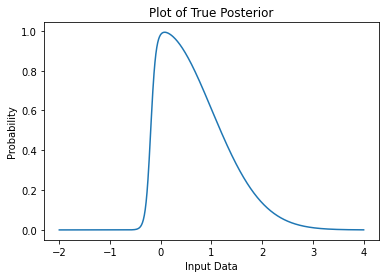

In [1]:
#hide_input

from matplotlib import pyplot as plt
import numpy as np

def logistic(z): return (1 + np.exp(-z)) ** -1

def p(z): return np.exp((-z ** 2) / 2) * logistic(20 * z + 4)

domain = np.linspace(-2, 4, 1000)
probs = p(domain)

plt.plot(domain, probs)
plt.title("Plot of True Posterior")
plt.xlabel("Input Data")
plt.ylabel("Probability")

The true closed form solution for the posterior above is {% fn 1 %}

$$
p(z) = \exp(\frac{-z^2}{2}) \cdot (1 + \exp(-z))^{-1}
$$

{{ This example can be found on pg 215 *Pattern Recognition and Machine Learning* by Christopher Bishop | fndetail: 1 }}

Unfortunately we will very rarely have direct access to the closed form solution for the posterior, so we must approximate. Enter: Pierre-Simon Laplace.

## A Solution from Parisian Dice Parlors
The Marquis de Laplace was a busy man. From his service to one Napoleon Bonaparte to his time frequenting gambling dens, there was no shortage of opportunities where Laplace needing to estimate the odds of an event. His contributions to the field of probability are almost unmatched: he rigorously formulated and popularized Bayes' Theorem, discovered probability generating functions, tied the least squares method to probability, and proved the central limit theorem which underpins the fields of statistics and probability today. But we are mostly concerned with a method developed in his 1774 manuscript *Mémoires de Mathématique et de Physique*.

### Deriving the Laplace Approximation

The Laplace Approximation is a very general method for working with integrals of the form
$$
\int^a_b \exp(M \cdot f(x)) dx
$$

where $M$ is some large number and $f(x)$ is at least twice differentiable.

The basic idea is that we can use a Taylor series around the global maximum of the function as an approximation of the original intractable integral. Suppose that $f(x)$ has a global maximum around $x_0$ and that $x_0$ is not an endpoint. Then, using the first few terms of the Taylor series we have

$$
f(x) = f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x-x_0)^2
$$

Knowing that $f(x_0)$ is a global maximum allows us to simplify a bit further since $f'(x_0)$ should be 0.

$$
f(x) \approx f(x_0) - \frac{1}{2}|f''(x_0)|(x-x_0)^2
$$

If we plug this back into our original integral equation we have
$$
\int^a_b \exp(M \cdot f(x)) dx \approx \int^a_b \exp(M \cdot f(x_0) - \frac{1}{2}|f''(x_0)|(x-x_0)^2) dx
$$

which further simplifies to
$$
\exp(M f(x_0)) \cdot \int^a_b \exp(- \frac{1}{2}|f''(x_0)|(x-x_0)^2) dx
$$

Recall that the Gaussian integral has the form

$$
\int \exp(-x)^2 dx = \sqrt{pi}
$$

so assuming that the integral we're interested in is an indefinite integral as is the case with most probability density functions then the Laplace Approximation allows us to use the Gaussian integral as an approximation. Using the Gaussian integral we can reduce the above equation into the final formulation of Laplace Approximation:

$$
\int^a_b \exp(M \cdot f(x)) dx \approx \sqrt{\frac{2 \pi}{M |f''(x_0)|)}}\exp(Mf(x_0))
$$

which improves in accuracy as $M \rightarrow \infty$.

### A Simple Application

As a brief aside, let's consider an application of the Laplace Approximation to a computer science problem. Suppose you wished to write a program to quickly compute $f(n) = n!$. Factorial equations are used all throughout physics, probability, and mathematics with practical uses in computing Bézier curves for computer graphics and time complexity equations for sorting algorithms.

A naive solution may look like

In [2]:
def factorial(n):
    result = 1
    for i in range(1, n+1):
        result *= i
    return result

factorial(5)

120

If we needed to run this function on very large integers thousands of times a second which may often be the case esperically in computer graphics, then we need this code to be especially fast. Multiplying increasing large integers in a for loop will probably become a bottleneck rather quickly, so this is a good opportunity to apply an approximation. Let's begin with the similar and useful Gamma function:

$$
\Gamma(n) = (n-1)! = \int_0^{\infty} \exp(-x) x^{n-1} dx
$$

Our factorial equation can then be written as

$$
n! = \Gamma(n + 1) = \int_0^{\infty} \exp(-x)x^ndx
$$

By performing a change of variables so that $x = nz$ and $dx = n dz$ we can derive the following

$$
= \int_0^{\infty} \exp(-nz) (nz)^n n dz \\
= n^{n+1} \int_0^{\infty} \exp(-nz)z^n dz \\
= n^{n+1} \int_0^{\infty} \exp(-nz) \exp(n \ln z) dz \\
= n^{n+1} \int_0^{\infty} \exp(n (\ln z - z)) dz
$$

Note that the final integral above has the form required for the Laplace Approximation: $\int^a_b \exp(M \cdot f(x)) dx$ since $f(z) = \ln z - z$ is twice differentiable. Recall that as $M \rightarrow \infty$, the approximation is more accurate so our final approximation of the factorial equation above will be more accurate for larger choices of $n$.

Using the Laplace approximation, we arrive at Stirling's Approximation for computing factorials:

$$
\int^a_b \exp(M \cdot f(x)) dx \approx \sqrt{\frac{2 \pi}{M |f''(x_0)|)}}\exp(Mf(x_0))\\
n^{n+1} \int_0^{\infty} \exp(n (\ln z - z)) dz \approx n^{n+1} \sqrt{\frac{2 \pi}{n |f''(x_0)|}}\exp(n f(x_0))
$$

$f(z) = \ln z - z$, so $f'(z) = \frac{1}{z} - 1$ and $f''(z) = -\frac{1}{z^2}$. The max of $f(z)$ is found at $z=1$, so $f(z_0=1) = -1$ and $f''(z_0 = 1) = -1$ as well. With this we arrive at the final approximation:

$$
n! \approx n^{n+1} \sqrt{\frac{2 \pi}{n}}e^{-n}
$$

which in Python would be

In [3]:
def stirling_approx(n):
    return (n ** (n+1)) * (np.sqrt((2 * np.pi) / n)) * np.exp(-n)
stirling_approx(5)

118.01916795759008

The error between the actual and approximation is

In [4]:
factorial(2) - stirling_approx(2)

0.08099564851101682